# Recommendations for Microsoft's Original Film Headlining New Streaming Service
by Sebastian Monzón and John Lemaster 

as first project in the Flatiron School's Data Science program in Chicago. August 2019.

## Imports
We'll begin by importing the necessary libraries and then we will load two databases from our "Data" folder. The other databases in the folder can be loaded by uncommenting out the read_csv functions.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

sns.set(style="whitegrid")
%matplotlib inline

In [2]:
# bom_df = pd.read_csv('Data/bom.movie_gross.csv')
# imdb_name_df = pd.read_csv('Data/imdb.name.basics.csv')
# imdb_akas_df = pd.read_csv('Data/imdb.title.akas.csv')
# imdb_basics_df = pd.read_csv('Data/imdb.title.basics.csv')
# imbd_crew_df = pd.read_csv('Data/imdb.title.crew.csv')
# imdb_principals_df = pd.read_csv('Data/imdb.title.principals.csv')
# imdb_ratings_df = pd.read_csv('Data/imdb.title.ratings.csv')
# rt_info_df = pd.read_csv('Data/rt.movie_info.tsv', sep = '\t')
# rt_reviews_df = pd.read_csv('Data/rt.reviews.tsv', sep = '\t', encoding ='ISO-8859-1')
# tmdb_movies_df = pd.read_csv('Data/tmdb.movies.csv')
# tn_budgets_df = pd.read_csv('Data/tn.movie_budgets.csv')

tmdb_data = pd.read_csv('Data/tmdb_movies_data.csv')
oscars = pd.read_csv('Data/oscars.csv')

## Data Cleaning

We will clean our two dataframes to get the features we want and take out the null values and duplicates.

#### Oscars Cleaning

In [3]:
oscars = oscars[(oscars['year'] >= 2000) & (oscars['year'] <= 2019)]
nominations = oscars.groupby('entity').count()['winner']
nominations.size

1462

#### TMDB Cleaning

In [4]:
tmdb_data.drop(columns = ['id', 'homepage', 'tagline', 'keywords', 'overview', 'runtime', 'production_companies', 'release_date'], inplace = True)
tmdb_data['cast'] = tmdb_data['cast'].apply(lambda x: str(x).split('|'))
tmdb_data['genres'] = tmdb_data['genres'].apply(lambda x: str(x).split('|'))
tmdb_cleaned = tmdb_data.sort_values(by = ['revenue_adj'], ascending = False)
tmdb_cleaned = tmdb_cleaned[~tmdb_cleaned.director.isna()]
tmdb_cleaned = tmdb_cleaned.drop_duplicates(subset ="imdb_id", keep = False)
tmdb_cleaned = tmdb_cleaned[(tmdb_cleaned['release_year'] >= 2000) &(tmdb_cleaned['release_year'] <=2019)]
tmdb_cleaned['budget'] = tmdb_data['budget']/1000000 
tmdb_cleaned['revenue'] = tmdb_data['revenue']/1000000
tmdb_cleaned['budget_adj'] = tmdb_cleaned['budget_adj']/1000000
tmdb_cleaned['revenue_adj'] = tmdb_cleaned['revenue_adj']/1000000
tmdb_cleaned['profit'] = tmdb_cleaned['revenue_adj'] - tmdb_cleaned['budget_adj']
tmdb_cleaned.shape

(7121, 14)

#### Merge Data

Now we will merge the Oscar information to the tmdb database with a left merge, because most films have not been nominated for an Academy Award.

In [5]:
merged_data = tmdb_cleaned
merged_data = merged_data.merge(nominations, left_on = 'original_title', right_on = 'entity', how = 'left')
merged_data.rename(columns = {'winner': 'nominations'}, inplace = True)
merged_data.shape

(7121, 15)

#### Generate Genres Data Frame From Merged Data

In [6]:
#First we create different data frames where a specific genre condition applies
comedies = merged_data[merged_data['genres'].apply(lambda x: 'Comedy' in x)]
dramas = merged_data[merged_data['genres'].apply(lambda x: 'Drama' in x)]
horrors = merged_data[merged_data['genres'].apply(lambda x: 'Horror' in x)]
adventures = merged_data[merged_data['genres'].apply(lambda x: 'Adventure' in x)]
fantasies = merged_data[merged_data['genres'].apply(lambda x: 'Fantasy' in x)]
thrillers = merged_data[merged_data['genres'].apply(lambda x: 'Thriller' in x)]
science_fictions = merged_data[merged_data['genres'].apply(lambda x: 'Science Fiction' in x)]
actions = merged_data[merged_data['genres'].apply(lambda x: 'Action' in x)]
crimes = merged_data[merged_data['genres'].apply(lambda x: 'Crime' in x)]
families = merged_data[merged_data['genres'].apply(lambda x: 'Family' in x)]
animations = merged_data[merged_data['genres'].apply(lambda x: 'Animation' in x)]
mysteries = merged_data[merged_data['genres'].apply(lambda x: 'Mystery' in x)]

#We create a list of those data frames and their names
genres = [comedies, dramas, horrors, adventures, fantasies, thrillers, science_fictions, actions, crimes, families, animations, mysteries]
genres_names = ['comedy', 'drama', 'horror', 'adventure', 'fantasy', 'thriller', 'science fiction', 'action', 'crime', 'family', 'animation', 'mystery']

#We loop through each genre data frame and extract three pieces of information: budget mean, revenue mean, and nominations
revenues_adj_mean = []
budget_adj_mean = []
oscar_nominations = []

for genre in genres:
    budget_adj_mean.append(genre.mean()['budget_adj'])
    revenues_adj_mean.append(genre.mean()['revenue_adj'])
    oscar_nominations.append(genre.sum()['nominations'])

#We prepare data for a data frame by creating a list of genre name, budget mean, revenue mean, and oscar nominations for each genre
to_df = []
for i in range(len(genres_names)):
    my_list = [genres_names[i], budget_adj_mean[i], revenues_adj_mean[i], oscar_nominations[i]]
    to_df.append(my_list)

#We clean up the newly created genres_df
genres_df = pd.DataFrame(to_df, columns = ['genre', 'budget', 'revenue', 'oscar_nominations'])
genres_df.sort_values(by = ['revenue'], inplace = True, ascending = False)
genres_df['profit'] = genres_df['revenue'] - genres_df['budget']
genres_df = genres_df.reset_index().drop(columns = ['index'])
genres_df.shape

(12, 5)

#### Creating Other Data Frames To Analyze Genres

These are all based on two data frame.

In [7]:
drama_adventure = merged_data[merged_data['genres'].apply(lambda x: ('Drama' in x) & ('Adventure' in x))].sort_values(by = ['profit'], ascending = False)
drama_fantasy = merged_data[merged_data['genres'].apply(lambda x: ('Drama' in x) & ('Fantasy' in x))].sort_values(by = ['profit'], ascending = False)
drama_comedy = merged_data[merged_data['genres'].apply(lambda x: ('Drama' in x) & ('Comedy' in x))].sort_values(by = ['profit'], ascending = False)
drama_adventure_oscars = drama_adventure.merge(nominations, left_on = 'original_title', right_on = 'entity', how = 'inner')
drama_fantasy_oscars = drama_fantasy.merge(nominations, left_on = 'original_title', right_on = 'entity', how = 'inner')
drama_comedy_oscars = drama_comedy.merge(nominations, left_on = 'original_title', right_on = 'entity', how = 'inner')
print(len(drama_adventure_oscars['original_title']), len(drama_fantasy_oscars['original_title']), len(drama_comedy_oscars['original_title']))

24 12 42


#### Make A Data Frame Showing Directors Who Have Worked on Drama-Adventure Oscar-Nominated Films

In [8]:
directors = drama_adventure[drama_adventure['profit'] > 10].groupby('director')
directors_oscars = drama_adventure[(drama_adventure['profit'] > 10) & (drama_adventure['nominations'] > 0)].groupby('director')
directors_by_profit_oscars = directors_oscars.mean().sort_values(by = ['profit'], ascending = False)[:10]
directors_by_profit_oscars.rename(index = {'Alejandro GonzÃ¡lez IÃ±Ã¡rritu': 'Alejandro Gonzalez Inarritu'}, inplace = True)
directors_by_profit_oscars.rename(index = {'Ethan Coen|Joel Coen': 'Coen Brothers'}, inplace = True)

#### Make A Data Frame Showing Highest Average-Grossing Drama-Adventure Actors 

In [9]:
casts = drama_adventure_oscars[['cast', 'profit', 'popularity']]
casts_actors = casts['cast'].values 
casts_profits = casts['profit'].values

casts_n_profit = []
for i, actors in enumerate(casts_actors):
    to_append = (actors, casts_profits[i])
    casts_n_profit.append(to_append)

actors_dict = {}
for tup in casts_n_profit:
    for actor in tup[0]:
        x = str(actor)
        if x == 'Michael PeÃ±a':
            x = 'Michael Pena'
        if x in actors_dict:
            actors_dict[x] += tup[1]/2 # this is to get the mean
        else:
            actors_dict[x] = tup[1]

sorted_actors = sorted(actors_dict.items(), key = lambda x: x[1], reverse = True)
actors = sorted_actors[:30]
actors = actors[0:3] + actors[8:]

#### Save our data frames and variables with 'pickle'

In [10]:
with open ('my_pickles/merged_data.p', 'wb') as writefile: 
    pickle.dump(merged_data, writefile)
with open ('my_pickles/genres_df.p', 'wb') as writefile: 
    pickle.dump(genres_df, writefile)
with open ('my_pickles/directors_by_profit_oscars.p', 'wb') as writefile: 
    pickle.dump(directors_by_profit_oscars, writefile)
with open ('my_pickles/nominations.p', 'wb') as writefile: 
    pickle.dump(nominations, writefile)
with open ('my_pickles/tmdb_cleaned.p', 'wb') as writefile: 
    pickle.dump(tmdb_cleaned, writefile)
with open ('my_pickles/genres_names.p', 'wb') as writefile: 
    pickle.dump(genres_names, writefile)
with open ('my_pickles/actors.p', 'wb') as writefile: 
    pickle.dump(actors, writefile)

## Visualizations

#### Genre Visualizations

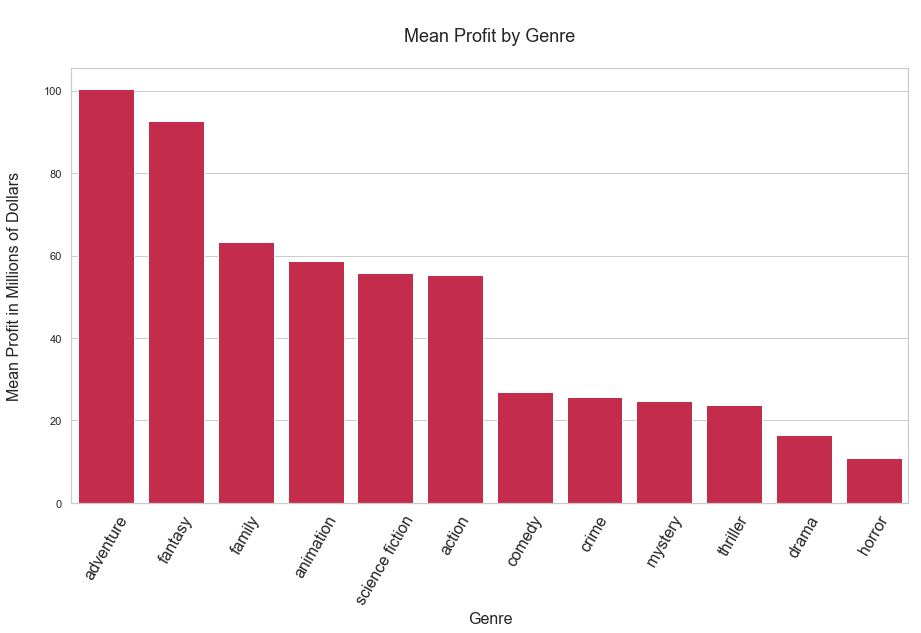

In [11]:
genres_df.sort_values(by = ['profit'], inplace = True, ascending = False)
plt.figure(figsize = (15,8))
sns.barplot(x = 'genre', y = 'profit', data = genres_df, color = 'crimson')
plt.title('\nMean Profit by Genre\n', fontsize = 18)
plt.ylabel('Mean Profit in Millions of Dollars\n', fontsize = 16)
plt.xticks(rotation=60, fontsize = 16)
plt.xlabel('Genre', fontsize = 16)
plt.xticks(fontsize = 16)
plt.show()

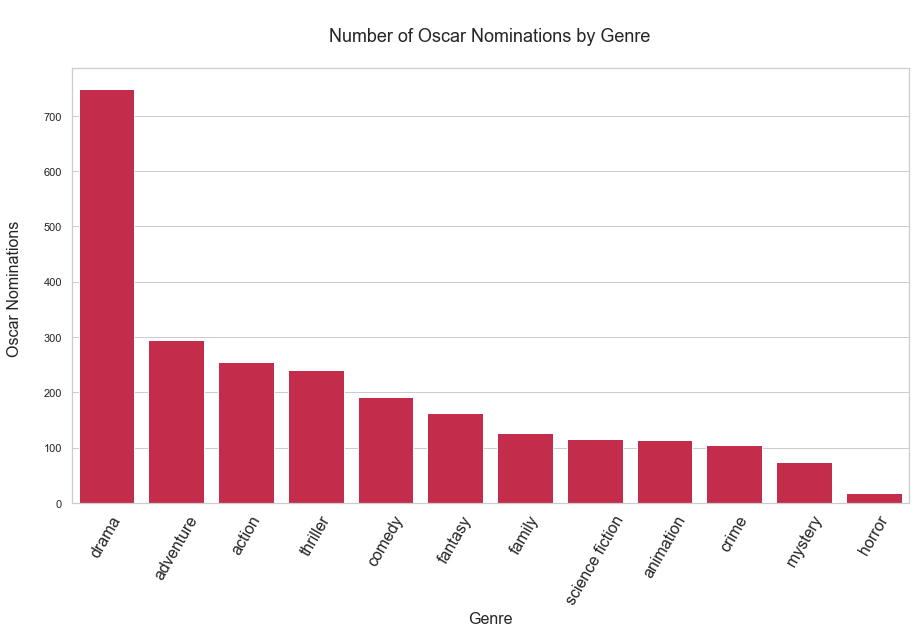

In [12]:
genres_df.sort_values(by = ['oscar_nominations'], ascending = False, inplace = True)
plt.figure(figsize = (15,8))
sns.barplot(x = 'genre', y = 'oscar_nominations', data = genres_df, color = 'crimson')
plt.xticks(rotation=60, fontsize = 16)
plt.xlabel('Genre', fontsize = 16)
plt.ylabel('Oscar Nominations \n', fontsize = 16)
plt.title('\nNumber of Oscar Nominations by Genre\n', fontsize = 18)
plt.show()

#### Director Visualizations

In [13]:
directors_by_profit_oscars.reset_index(inplace = True)

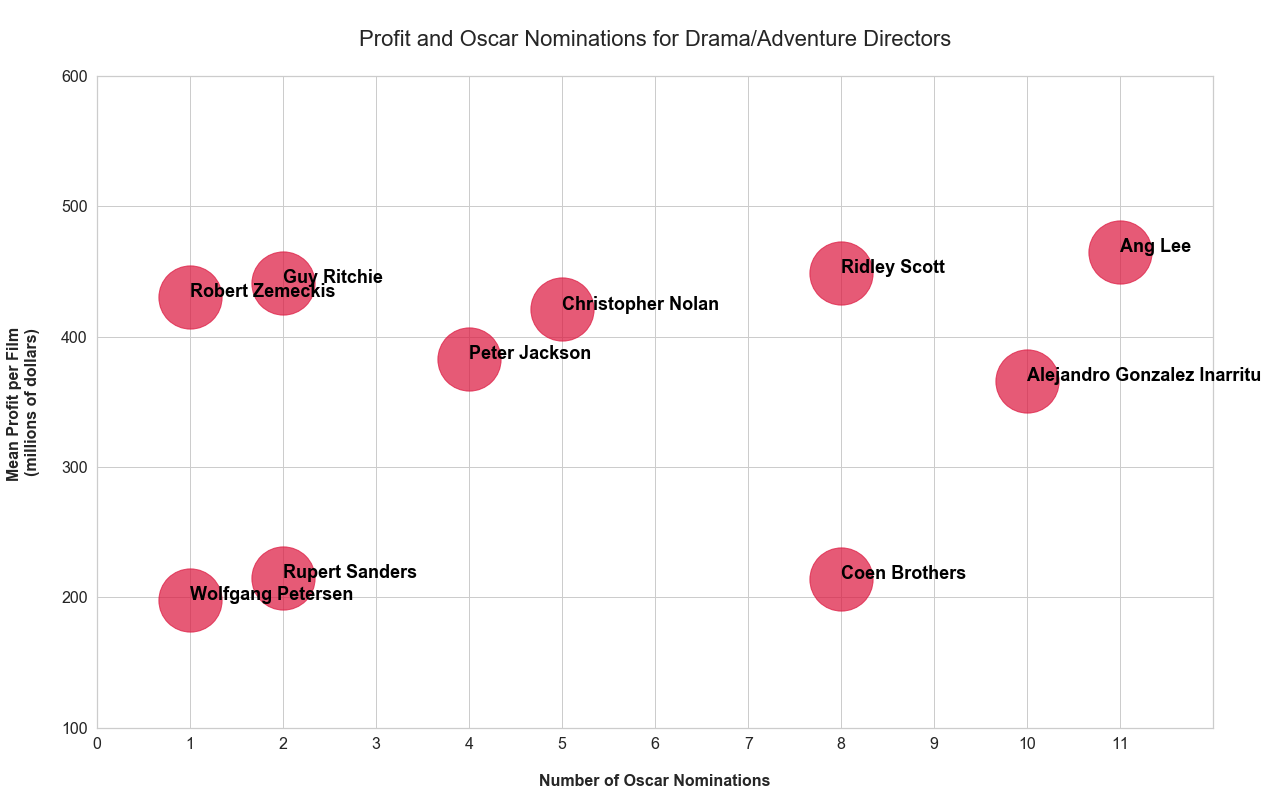

In [14]:
plt.figure(figsize = (20,12))

z = directors_by_profit_oscars['nominations'].values
y = directors_by_profit_oscars['profit'].values
n = directors_by_profit_oscars['director'].values


plt.scatter(x = z, y = y, s = 4000, color = 'crimson', alpha = .7)


for i, txt in enumerate(n):
    plt.annotate(txt, (z[i], y[i]), fontsize = 18, fontweight = 'bold', color = 'black')

plt.xlabel('\nNumber of Oscar Nominations', fontsize = 16, fontweight = 'bold')
plt.xticks(range(0,12),fontsize = 16)
plt.yticks(fontsize = 16)
plt.ylabel('Mean Profit per Film \n(millions of dollars)\n', fontsize = 16, fontweight = 'bold')
plt.title('\nProfit and Oscar Nominations for Drama/Adventure Directors\n', fontsize = 22)
plt.xlim(0,12)
plt.ylim(100, 600)

plt.show()          

#### Actors Visualization

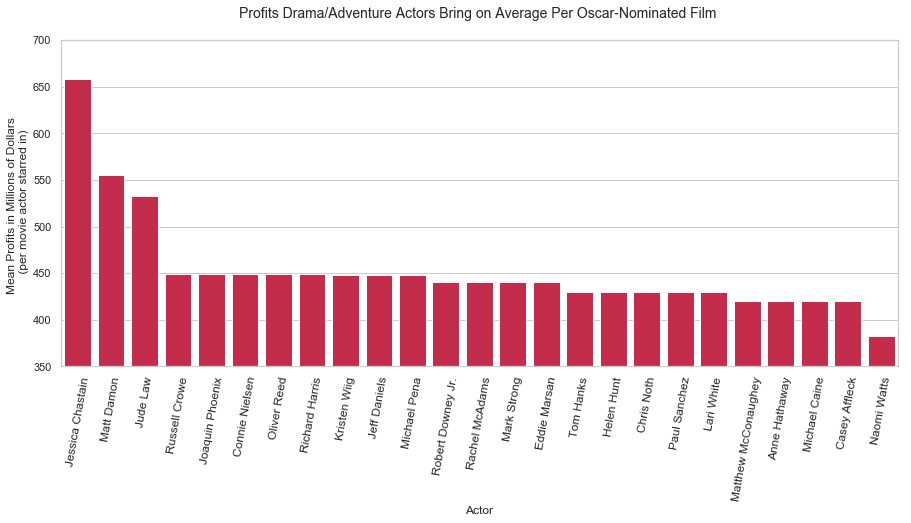

In [15]:
actors_plot = []
profits_plot = []
for actor in actors:
    actors_plot.append(actor[0])
    profits_plot.append(actor[1])

plt.figure(figsize = (15,6))
sns.barplot(x = actors_plot, y = profits_plot, color = 'crimson')
plt.xticks(rotation=80, fontsize = 12)
plt.xlabel('Actor', fontsize = 12)
plt.ylabel('Mean Profits in Millions of Dollars \n (per movie actor starred in)', fontsize = 12)
plt.title('Profits Drama/Adventure Actors Bring on Average Per Oscar-Nominated Film \n', fontsize = 14)
plt.ylim(350,700)
plt.show()